# Carrier Recovery & PED/FEDs

## Frequency Error Detector (FED)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

from rfproto import measurements, plot, sig_gen

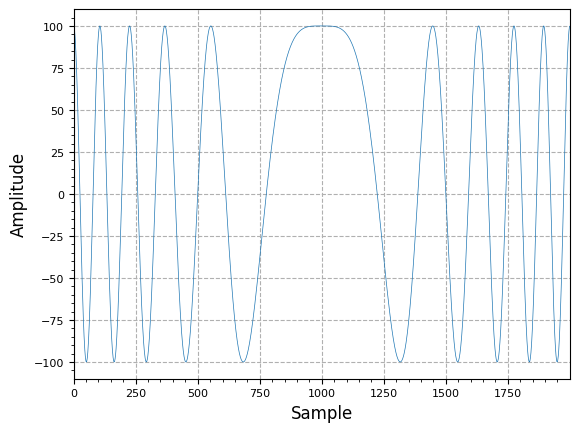

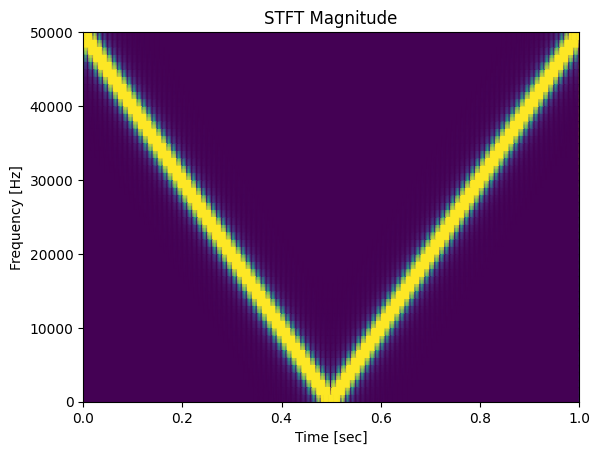

In [2]:
fs = 100.0e3
f_start = -fs/2
f_end = fs/2
num_samples = int(fs) # 1 second

lfm_chirp_sig = sig_gen.cmplx_dt_lfm_chirp(100, f_start, f_end, fs, num_samples)
mid_pt = int(len(lfm_chirp_sig)/2)
margin = 1000
plot.samples(np.real(lfm_chirp_sig[mid_pt - margin:mid_pt + margin]))
plt.show()

f, t, Zxx = signal.stft(np.real(lfm_chirp_sig), fs, nperseg=100)
plt.pcolormesh(t, f, np.abs(Zxx), vmin=0, vmax=2, shading='gouraud')
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

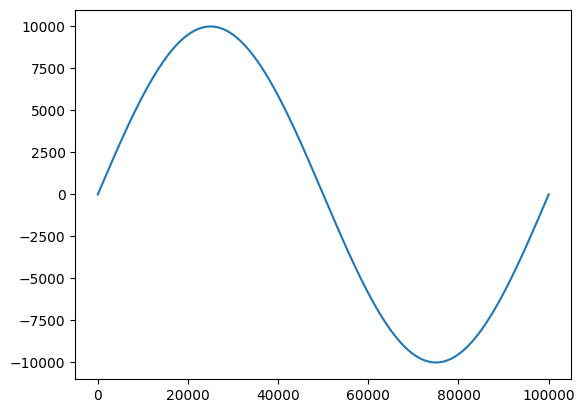

In [3]:
i_z1 = 0
q_z1 = 0
freq_disc = np.zeros(len(lfm_chirp_sig))

for i in range(len(lfm_chirp_sig)):
    i_val = np.real(lfm_chirp_sig[i])
    q_val = np.imag(lfm_chirp_sig[i])
    a0 = i_z1 * q_val
    a1 = q_z1 * i_val
    freq_disc[i] = a1 - a0
    i_z1 = i_val
    q_z1 = q_val

plt.plot(freq_disc)
plt.show()

Blind, Non-Data Aided (NDA) FLL can be made by RRC/match filtering, Mth power to fold phase into sinusoid which has frequency offset at $M$ times the CFO, LPF'ing then using L&R type autocorrelation FED (see above) loop filtered to drive frequency error to zero.

## Phase Error Detector (PED)

## References

* [High modulation index PSK - carrier recovery - DSP Stack Exchange](https://dsp.stackexchange.com/questions/17297/high-modulation-index-psk-carrier-recovery)
  + [How does this FLL work? - DSP Stack Exchange](https://dsp.stackexchange.com/questions/42239/how-does-this-fll-work/52163#52163)
* [Mathworks Carrier Synchronizer System Object](https://www.mathworks.com/help/comm/ref/comm.carriersynchronizer-system-object.html)